In [14]:
# testing out the modAL package for active learning
from modal.models import ActiveLearner
from modal.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import utils

from copy import deepcopy

import random
from importlib import reload
from helpers import *

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, WhiteKernel, RationalQuadratic
import matplotlib.pyplot as plt

In [3]:
# some basic definitions

reduced_train_variables = ['Nb_power_watts','Sb_power_watts','Ta_power_watts','V_power_watts']
train_variables = ['Ta_power_watts','Sb_power_watts','Nb_power_watts','Ti_power_watts','Fe_power_watts','V_power_watts',
                   'Ta_angle_mm','Sb_angle_mm','Nb_angle_mm','Ti_angle_mm','Fe_angle_mm','V_angle_mm']
predict_variables = ['Ta_measured_percent','Sb_measured_percent','Nb_measured_percent','Ti_measured_percent','Fe_measured_percent','V_measured_percent']

In [4]:
# let's define all of our scalers for the X and Y data
# we need to fit the scaling functions based on the entire dataset
fpath = 'Ti-Nb-V-Ta-Fe-Sb_sputtering_data_complete_clean.csv'

X_scaling_dataset,y_scaling_dataset = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)

xScalers = [preprocessing.StandardScaler().fit(x.reshape(-1,1)) for x in X_scaling_dataset]
Scalers = [preprocessing.StandardScaler().fit(y.reshape(-1,1)) for y in y_scaling_dataset]



In [5]:
from sklearn import preprocessing

# functions for scaling the X and Y datasets prior to training
def X_scaling(X_dataset,scaling_list):
    X_transformed = np.array([xScaler.transform(x.reshape(-1,1)).reshape(len(x)) for x,xScaler in zip(X_dataset,scaling_list)])
    return X_transformed


def Y_scaling(Y_dataset,scaling_list):
    y_transformed = np.array([Scaler.transform(y.reshape(-1,1)).reshape(len(y)) for y,Scaler in zip(Y_dataset,scaling_list)])
    return y_transformed

In [6]:
# writing a function for the active learning loop to save some space and make things *pretty*

np.random.seed(42)

def active_learning_loop(test_Xin,test_yin,X_pretrain,y_pretrain,y_originalin,no_tests = 10,no_initial_samples = 1):

    # Initialize MAE list of lists
    all_mae_list = []

    # iterate through all the tests you want to do, randomly sampling each time
    for ii in range(no_tests):

        # deepcopy the original datasets at each iteration
        test_X = deepcopy(test_Xin)
        test_y = deepcopy(test_yin)
        y_original = deepcopy(y_originalin)

        # first create the model
        kernel = C(1.0, (1e-6, 1e6)) * Matern(10, (1e-6, 1e6)) + C(1.0, (1e-6, 1e6))*RationalQuadratic(10) + C(1.0, (1e-6, 1e6))*WhiteKernel(10,(1e-6,1e6))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

        # select a random sample from the main dataset to train the model on
        train_idx = np.random.choice(range(0,len(test_X)), no_initial_samples, replace=False)
        X_train = test_X[train_idx]
        Y_train = test_y[train_idx]

        # add the transfer learning datasets as well
        for X,y in zip(X_pretrain,y_pretrain):
            X_train = np.vstack([X_train,X])
            Y_train = np.vstack([Y_train,y])

        # Remaining data
        X_untrained = np.delete(test_X, train_idx, axis=0)
        Y_untrained = np.delete(test_y, train_idx, axis=0)
        Y_original_untrained = np.delete(y_original, train_idx, axis=0)

        # initialize mae list
        mae_list = []

        # Main active learning loop
        for i in range(len(X_untrained)):  # Adjust based on your stopping criteria
            # Re-train the GPR model
            gp.fit(X_train, Y_train)
        
            # Make predictions on untrained data
            y_pred, sigma = gp.predict(X_untrained, return_std=True)

            # convert back to original scale
            y_inverted = np.array([Scaler.inverse_transform(y.reshape(1,-1)).reshape(len(y)) for y,Scaler in zip(y_pred.T,Scalers)]).T

            # Calculate MAE
            mae_list.append(np.mean(np.abs(y_inverted - Y_original_untrained)))
        
            # Uncertainty Sampling
            # take the average across all elements in a sample
            sigma = np.array([np.mean(sig) for sig in sigma])
            uncertainty_idx = np.argmax(sigma)
        
            # Update training and untrained sets
            X_train = np.vstack([X_train, X_untrained[uncertainty_idx]])
            Y_train = np.vstack([Y_train, Y_untrained[uncertainty_idx]])
            X_untrained = np.delete(X_untrained, uncertainty_idx, axis=0)
            Y_untrained = np.delete(Y_untrained, uncertainty_idx, axis=0)
            Y_original_untrained = np.delete(Y_original_untrained, uncertainty_idx, axis=0)
    
        all_mae_list.append(mae_list)

    return all_mae_list


In [8]:
# import the unary dataset
fpath = 'unary_only.csv'
X_one_raw,y_one_raw = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)
# scale the dataset
X_unary = X_scaling(X_one_raw,xScalers).T
Y_unary = Y_scaling(y_one_raw,Scalers).T

##############################
# import the ternary dataset
fpath = 'ternary_only.csv'
X_three_raw,y_three_raw = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)
# scale the dataset
X_ternary = X_scaling(X_three_raw,xScalers).T 
Y_ternary = Y_scaling(y_three_raw,Scalers).T
y_original_ternary = deepcopy(y_three_raw).T

##############################
# import the quarternary dataset
fpath = 'quarternary_only.csv'
X_four_raw,y_four_raw = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)
# scale the dataset
X_quarternary = X_scaling(X_four_raw,xScalers).T
Y_quarternary = Y_scaling(y_four_raw,Scalers).T
y_original_quarternary = deepcopy(y_four_raw).T

##############################
# import the quinternary dataset
fpath = 'quinternary_only.csv'
X_five_raw,y_five_raw = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)
# scale the dataset
X_quinternary = X_scaling(X_five_raw,xScalers).T
Y_quinternary = Y_scaling(y_five_raw,Scalers).T
y_original_quinternary = deepcopy(y_five_raw).T

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\Ap

Text(0, 0.5, 'Mean Absolute Error')

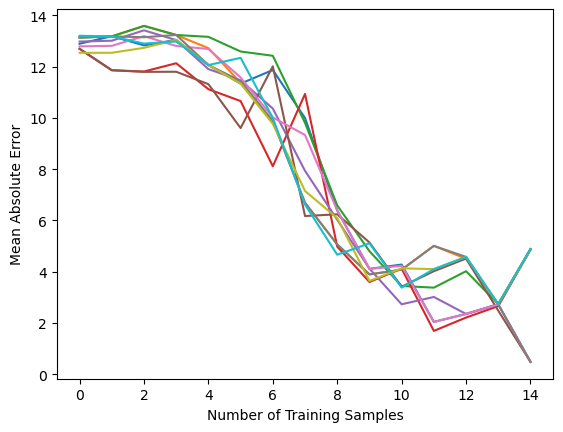

In [9]:
# active learning on the ternary alone, no transfer learning
ternary_mae_lists = active_learning_loop(X_ternary,Y_ternary,[X_unary],[Y_unary],y_original_ternary,no_tests=10)

ternary_mae_lists = np.array(ternary_mae_lists)
mean_ternary_mae = np.array([np.mean(array) for array in ternary_mae_lists.T])
ternary_stds = np.array([np.std(array) for array in ternary_mae_lists.T])

plt.figure()
for mae_list in ternary_mae_lists:
    plt.plot(mae_list)

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\

Text(0, 0.5, 'Mean Absolute Error')

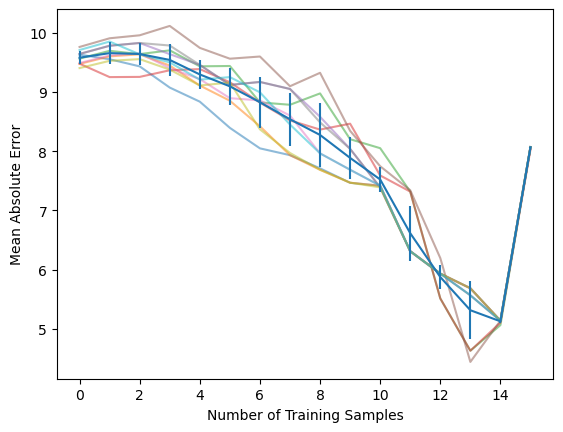

In [10]:
# active learning on the quarternary alone, no transfer learning
quarternary_mae_lists = active_learning_loop(X_quarternary,Y_quarternary,[X_unary],[Y_unary],y_original_quarternary,no_tests=10)

quarternary_mae_lists = np.array(quarternary_mae_lists)
mean_quarternary_mae = np.array([np.mean(array) for array in quarternary_mae_lists.T])
quarternary_stds = np.array([np.std(array) for array in quarternary_mae_lists.T])

plt.figure()
for mae_list in quarternary_mae_lists:
    plt.plot(mae_list,alpha=0.5)

plt.errorbar(range(len(mean_quarternary_mae)),mean_quarternary_mae,yerr=quarternary_stds)

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJ

Text(0, 0.5, 'Mean Absolute Error')

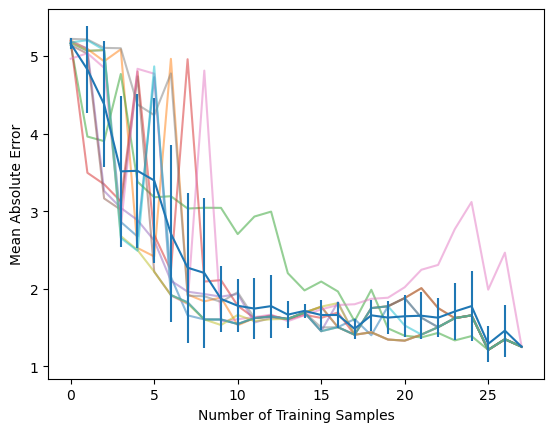

In [11]:
# active learning on the quarternary alone, no transfer learning
quinternary_mae_lists = active_learning_loop(X_quinternary,Y_quinternary,[X_unary],[Y_unary],y_original_quinternary,no_tests=10)

quinternary_mae_lists = np.array(quinternary_mae_lists)
mean_quinternary_mae = np.array([np.mean(array) for array in quinternary_mae_lists.T]) 
quinternary_stds = np.array([np.std(array) for array in quinternary_mae_lists.T])

plt.figure()
for mae_list in quinternary_mae_lists:
    plt.plot(mae_list,alpha=0.5)

plt.errorbar(range(len(mean_quinternary_mae)),mean_quinternary_mae,yerr=quinternary_stds)

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJ

Text(0, 0.5, 'Mean Absolute Error')

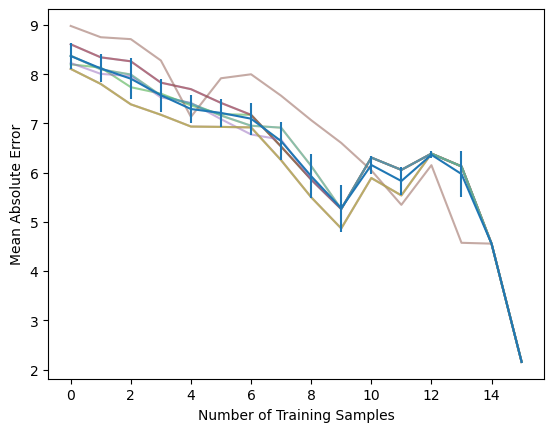

In [12]:
# train on ternary, test on quarternary
quart3_mae_lists = active_learning_loop(X_quarternary,Y_quarternary,[X_unary,X_ternary],[Y_unary,Y_ternary],y_original_quarternary,no_tests=10)

quart3_mae_lists = np.array(quart3_mae_lists)
mean_quart3_mae = np.array([np.mean(array) for array in quart3_mae_lists.T])
quart3_stds = np.array([np.std(array) for array in quart3_mae_lists.T])

plt.figure()
for mae_list in quart3_mae_lists:
    plt.plot(mae_list,alpha=0.5)

plt.errorbar(range(len(mean_quart3_mae)),mean_quart3_mae,yerr=quart3_stds)
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJ

Text(0, 0.5, 'Mean Absolute Error')

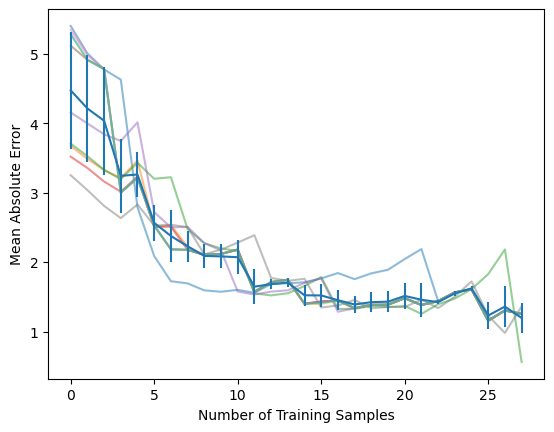

In [13]:
# train on ternary, test on quinternary
quin3_mae_lists = active_learning_loop(X_quinternary,Y_quinternary,[X_unary,X_ternary],[Y_unary,Y_ternary],y_original_quinternary,no_tests=10)

quin3_mae_lists = np.array(quin3_mae_lists)
mean_quin3_mae = np.array([np.mean(array) for array in quin3_mae_lists.T])
quin3_stds = np.array([np.std(array) for array in quin3_mae_lists.T])

plt.figure()
for mae_list in quin3_mae_lists:
    plt.plot(mae_list,alpha=0.5)

plt.errorbar(range(len(mean_quin3_mae)),mean_quin3_mae,yerr=quin3_stds) 

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\A

Text(0, 0.5, 'Mean Absolute Error')

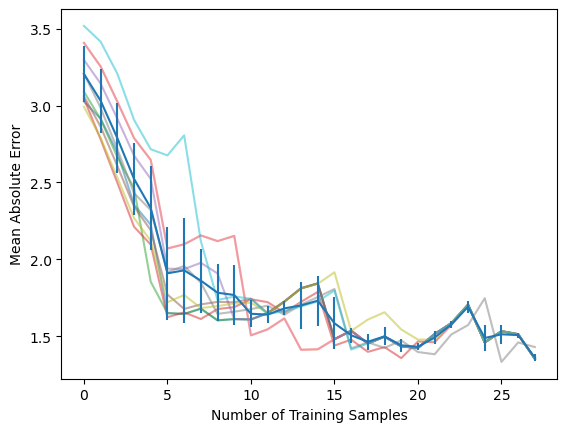

In [14]:
# train on quarternary, test on quinternary
quin4_mae_lists = active_learning_loop(X_quinternary,Y_quinternary,[X_unary,X_quarternary],[Y_unary,Y_quarternary],y_original_quinternary,no_tests=10)

quin4_mae_lists = np.array(quin4_mae_lists)
mean_quin4_mae = np.array([np.mean(array) for array in quin4_mae_lists.T])
quin4_stds = np.array([np.std(array) for array in quin4_mae_lists.T])

plt.figure()
for mae_list in quin4_mae_lists:
    plt.plot(mae_list,alpha=0.5) 

plt.errorbar(range(len(mean_quin4_mae)),mean_quin4_mae,yerr=quin4_stds) 

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\User

<ErrorbarContainer object of 3 artists>

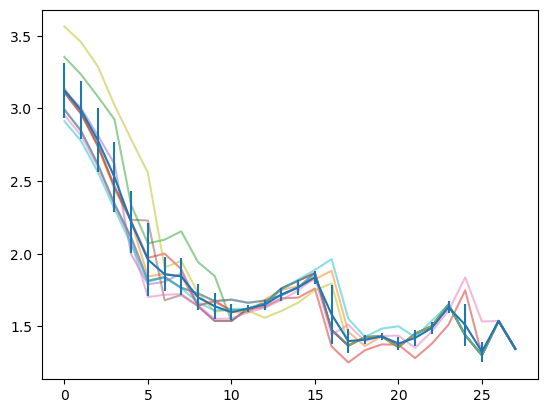

In [15]:
# train on quarternary and ternary, test on quinternary
quin43_mae_lists = active_learning_loop(X_quinternary,Y_quinternary,[X_unary,X_ternary,X_quarternary],[Y_unary,Y_ternary,Y_quarternary],y_original_quinternary,no_tests=10)

quin43_mae_lists = np.array(quin43_mae_lists)
mean_quin43_mae = np.array([np.mean(array) for array in quin43_mae_lists.T])
quin43_stds = np.array([np.std(array) for array in quin43_mae_lists.T])

plt.figure()
for mae_list in quin43_mae_lists:
    plt.plot(mae_list,alpha=0.5)

plt.errorbar(range(len(mean_quin43_mae)),mean_quin43_mae,yerr=quin43_stds)  

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

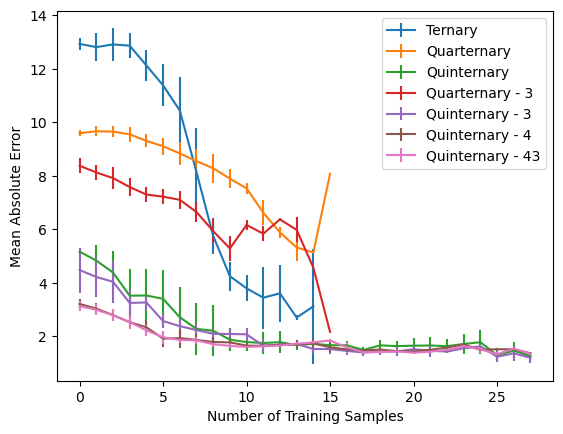

In [16]:
plt.figure()
plt.errorbar(range(len(mean_ternary_mae)),mean_ternary_mae,yerr=ternary_stds,label='Ternary')
plt.errorbar(range(len(mean_quarternary_mae)),mean_quarternary_mae,yerr=quarternary_stds,label='Quarternary')
plt.errorbar(range(len(mean_quinternary_mae)),mean_quinternary_mae,yerr=quinternary_stds,label='Quinternary')
plt.errorbar(range(len(mean_quart3_mae)),mean_quart3_mae,yerr=quart3_stds,label='Quarternary - 3')
plt.errorbar(range(len(mean_quin3_mae)),mean_quin3_mae,yerr=quin3_stds,label='Quinternary - 3')
plt.errorbar(range(len(mean_quin4_mae)),mean_quin4_mae,yerr=quin4_stds,label='Quinternary - 4')
plt.errorbar(range(len(mean_quin43_mae)),mean_quin43_mae,yerr=quin43_stds,label='Quinternary - 43')

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

plt.legend()

In [17]:
# save all of the errors that you get

tdf = pd.DataFrame({'mae':mean_ternary_mae,'yerr':ternary_stds})
qdf = pd.DataFrame({'mae':mean_quarternary_mae,'yerr':quarternary_stds})
fdf = pd.DataFrame({'mae':mean_quinternary_mae,'yerr':quinternary_stds})
qtdf = pd.DataFrame({'mae':mean_quart3_mae,'yerr':quart3_stds})
ftdf = pd.DataFrame({'mae':mean_quin3_mae,'yerr':quin3_stds})
fqdf = pd.DataFrame({'mae':mean_quin4_mae,'yerr':quin4_stds})
ftqdf = pd.DataFrame({'mae':mean_quin43_mae,'yerr':quin43_stds})

tdf.to_csv('errors/GPR_ternary_only_transfer_learn.csv',index=False)
qdf.to_csv('errors/GPR_quarternary_only_transfer_learn.csv',index=False)
fdf.to_csv('errors/GPR_quinternary_only_transfer_learn.csv',index=False)
qtdf.to_csv('errors/GPR_quarternary_from_ternary_transfer_learn.csv',index=False)
ftdf.to_csv('errors/GPR_quinternary_from_ternary_transfer_learn.csv',index=False)
fqdf.to_csv('errors/GPR_quinternary_from_quarternary_transfer_learn.csv',index=False)
ftqdf.to_csv('errors/GPR_quinternary_from_all_transfer_learn.csv',index=False)